<a href="https://colab.research.google.com/github/GerardWalsh/car-dataset/blob/master/golf_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.model_selection import train_test_split
from PIL import Image
import requests
import os

In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

from tensorflow.keras import models, layers, optimizers, utils, datasets, preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import resnet, vgg16, inception_v3

tf.random.set_seed(17)

TensorFlow 2.x selected.


In [0]:
!rm -rf cousteau
!git clone https://github.com/datawookie/cousteau.git
  
from cousteau.keras.plot import plot_history

Cloning into 'cousteau'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 18 (delta 6), reused 16 (delta 4), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [0]:
!rm -rf car-dataset # allows us to re-clone the dataset w/ updates and get the changes - if folder exists, clone does not work and we won't get anychanges
!git clone https://github.com/GerardWalsh/car-dataset.git

Cloning into 'car-dataset'...
remote: Enumerating objects: 161, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 161 (delta 16), reused 156 (delta 11), pack-reused 0
Receiving objects: 100% (161/161), 6.58 MiB | 5.38 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [0]:
image_paths = list(paths.list_images("car-dataset/train"))

images = []
labels = []

for path in image_paths:
  img = preprocessing.image.load_img(path, target_size=(224, 224))
  img = np.expand_dims(img, axis=0)
  
  images.append(img)

  label = path.split(os.path.sep)[-2]
  labels.append(1 if label == "7" else 0)

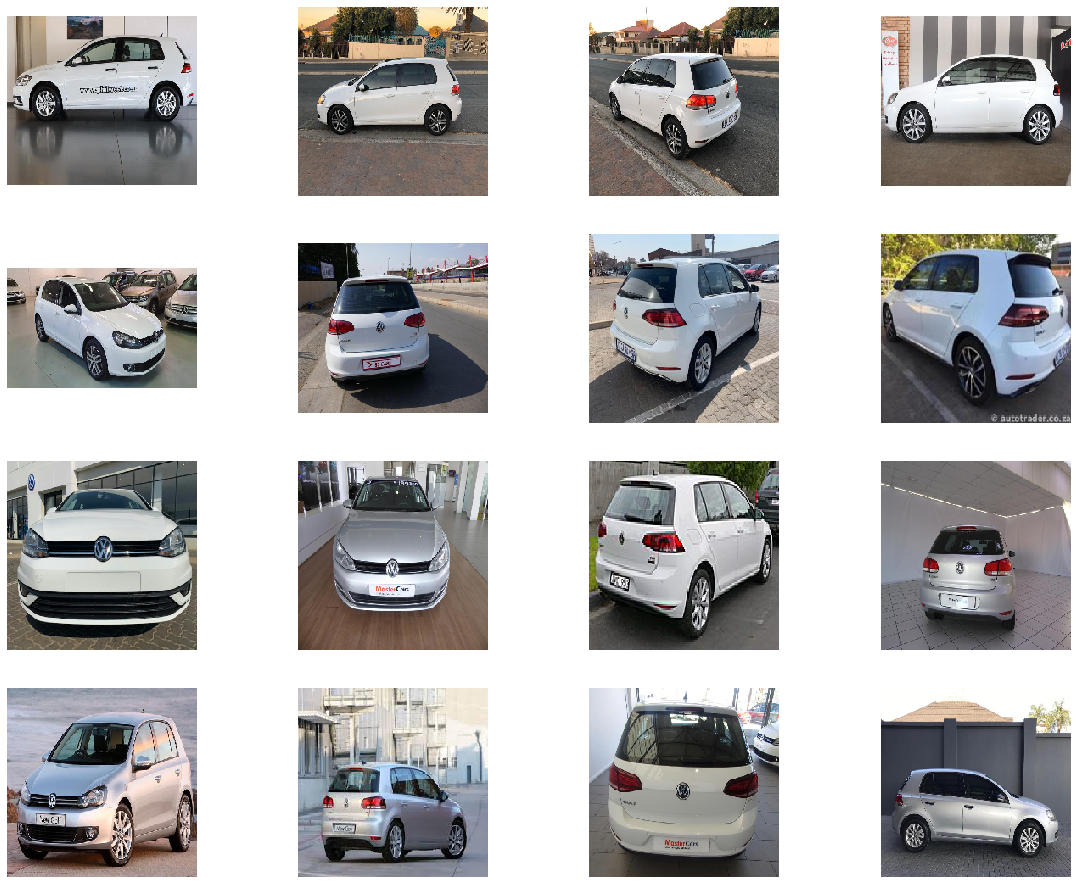

In [0]:
fig = plt.figure(figsize = (20, 16))

for i, img in zip(range(16), random.sample(images, 16)):
  fig.add_subplot(4, 4, i+1)
  plt.axis('off')
  plt.imshow(np.squeeze(img))

plt.show()

In [0]:
datagen = preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [0]:
def augment_image(image, replicates=4):
    images = [image]
    i = 1
    for batch in datagen.flow(image, batch_size=1):
        images.append(batch)
        i += 1
        if i >= replicates:
            break
    return images

In [0]:
REPLICATES = 4

In [0]:
images = [augment_image(image, REPLICATES) for image in images]

In [0]:
images = [image for sublist in images for image in sublist]

In [0]:
len(images)

520

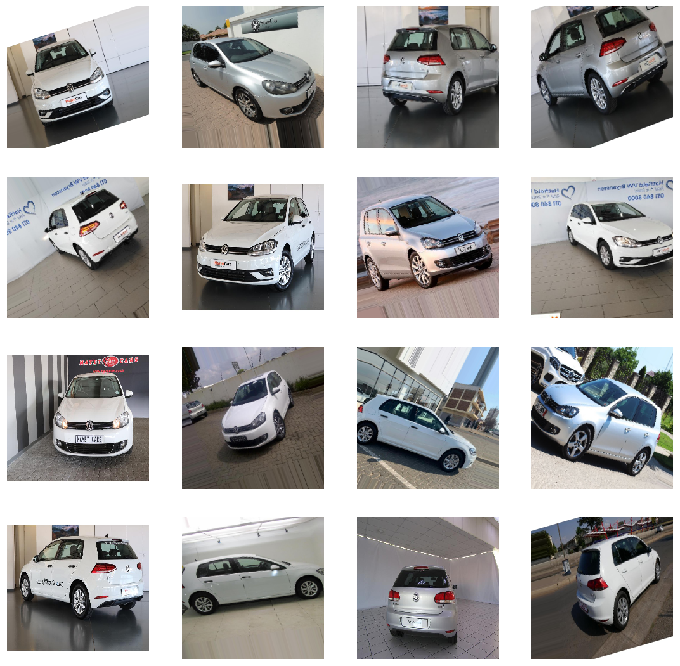

In [0]:
fig = plt.figure(figsize = (12, 12))

for i, img in zip(range(16), random.sample(images, 16)):
  fig.add_subplot(4, 4, i+1)
  plt.axis('off')
  # Transformations result in float32, so cast to uint8.
  plt.imshow(np.squeeze(img).astype('uint8'))

plt.show()

In [0]:
labels = [[label] * REPLICATES for label in labels]
labels = [label for sublist in labels for label in sublist]

In [0]:
labels = np.array(labels)

In [0]:
images = np.concatenate(images)

In [0]:
input_shape = images.shape[1:]

In [0]:
images = resnet.preprocess_input(images)

In [0]:
(X_train, X_test, y_train, y_test) = train_test_split(images, labels, test_size=0.2, random_state=13)

In [0]:
model = models.Sequential()

model.add(layers.Conv2D(20, kernel_size=5, activation = 'relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=2))

model.add(layers.Conv2D(50, kernel_size=5, activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size=2))      

model.add(layers.Flatten())
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(2, activation = 'softmax'))

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 20)      1520      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 20)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 106, 106, 50)      25050     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 50)        0         
_________________________________________________________________
flatten (Flatten)            (None, 140450)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                4494432   
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                1

In [0]:
batch_size = 8
epochs = 30

In [0]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.00001),
    metrics=['accuracy']
)

In [0]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.2
)

Train on 332 samples, validate on 84 samples
Epoch 1/30
332/332 [==============================] - 7s 20ms/sample - loss: 1.0321 - accuracy: 0.5693 - val_loss: 1.3298 - val_accuracy: 0.5357
Epoch 2/30
332/332 [==============================] - 2s 5ms/sample - loss: 0.7550 - accuracy: 0.6325 - val_loss: 1.2137 - val_accuracy: 0.5714
Epoch 3/30
332/332 [==============================] - 2s 5ms/sample - loss: 0.5846 - accuracy: 0.7259 - val_loss: 1.3458 - val_accuracy: 0.5595
Epoch 4/30
332/332 [==============================] - 2s 5ms/sample - loss: 0.5776 - accuracy: 0.7259 - val_loss: 0.9630 - val_accuracy: 0.5476
Epoch 5/30
332/332 [==============================] - 2s 5ms/sample - loss: 0.4505 - accuracy: 0.7831 - val_loss: 0.9242 - val_accuracy: 0.5595
Epoch 6/30
332/332 [==============================] - 2s 5ms/sample - loss: 0.4104 - accuracy: 0.8133 - val_loss: 1.0410 - val_accuracy: 0.5119
Epoch 7/30
332/332 [==============================] - 2s 5ms/sample - loss: 0.3941 - accur

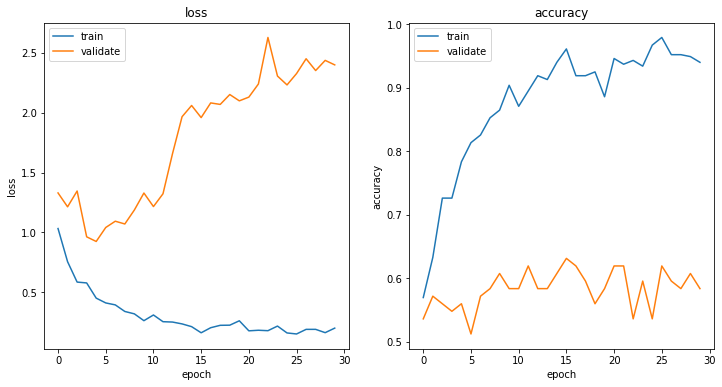

In [0]:
plot_history(history)

In [0]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 64.42% 
Test loss     = 0.673550


# Transfer learning

In [0]:
base_model = resnet.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

94773248/94765736 [==============================] - 35s 0us/step


In [0]:
# base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [0]:
model = models.Sequential()

model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1605648   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 25,193,458
Trainable params: 25,140,306
Non-trainable params: 53,152
_____________________________________

In [0]:
base_model.trainable = False

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1605648   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 25,193,458
Trainable params: 1,605,714
Non-trainable params: 23,587,744
__________________________________

In [0]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(lr=0.00001),
    metrics=['accuracy']
)

In [0]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=45,
    verbose=1,
    validation_split=0.2
)

Train on 332 samples, validate on 84 samples
Epoch 1/45
332/332 [==============================] - 10s 32ms/sample - loss: 1.0895 - accuracy: 0.5090 - val_loss: 0.8012 - val_accuracy: 0.5357
Epoch 2/45
332/332 [==============================] - 4s 13ms/sample - loss: 0.8057 - accuracy: 0.6114 - val_loss: 0.7433 - val_accuracy: 0.5833
Epoch 3/45
332/332 [==============================] - 4s 13ms/sample - loss: 0.6397 - accuracy: 0.7018 - val_loss: 0.6744 - val_accuracy: 0.6190
Epoch 4/45
332/332 [==============================] - 4s 13ms/sample - loss: 0.5639 - accuracy: 0.7470 - val_loss: 0.6659 - val_accuracy: 0.6190
Epoch 5/45
332/332 [==============================] - 4s 13ms/sample - loss: 0.4448 - accuracy: 0.8012 - val_loss: 0.6455 - val_accuracy: 0.6429
Epoch 6/45
332/332 [==============================] - 4s 13ms/sample - loss: 0.4131 - accuracy: 0.8223 - val_loss: 0.6240 - val_accuracy: 0.6548
Epoch 7/45
332/332 [==============================] - 4s 13ms/sample - loss: 0.3567 

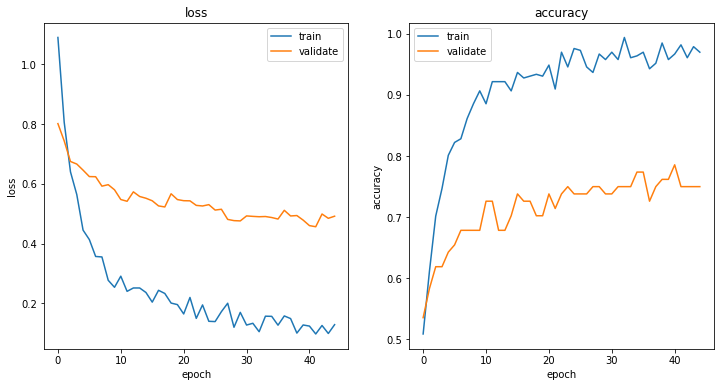

In [0]:
plot_history(history)

In [0]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 77.88% 
Test loss     = 0.466459


# Fine tune

In [0]:
# for i, layer in enumerate(base_model.layers):
#    print(i, layer.name)

In [0]:
# base_model.summary()

In [0]:
def trainable_weights(model):
  return sum([int(tf.size(weights)) for weights in model.trainable_weights])

# How many trainable weights in the base model?
trainable_weights(base_model)

0

In [0]:
# Make the whole base model trainable (using model property).
base_model.trainable = True
# How many trainable weights in the base model?
trainable_weights(base_model)
# Check that this agrees with the model summary.

23534592

In [0]:
# Set all layers not trainable (using layer properties).
for layer in base_model.layers:
   layer.trainable = False
# Set top two convolutional layers trainable.
for layer in base_model.layers[171:174]:
   layer.trainable = True
    
# How many trainable weights in the base model?
trainable_weights(base_model)
# Check that this agrees with the model summary.

1054720

In [0]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(lr=0.00001),
    metrics=['accuracy']
)

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1605648   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 25,193,458
Trainable params: 2,660,434
Non-trainable params: 22,533,024
__________________________________

In [0]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=10,
    verbose=1,
    validation_split=0.2
)

Train on 332 samples, validate on 84 samples
Epoch 1/10
332/332 [==============================] - 10s 30ms/sample - loss: 0.1272 - accuracy: 0.9669 - val_loss: 0.4889 - val_accuracy: 0.7500
Epoch 2/10
332/332 [==============================] - 4s 13ms/sample - loss: 0.1192 - accuracy: 0.9729 - val_loss: 0.4478 - val_accuracy: 0.7857
Epoch 3/10
332/332 [==============================] - 4s 14ms/sample - loss: 0.0733 - accuracy: 0.9910 - val_loss: 0.4252 - val_accuracy: 0.7738
Epoch 4/10
332/332 [==============================] - 4s 13ms/sample - loss: 0.1055 - accuracy: 0.9699 - val_loss: 0.3932 - val_accuracy: 0.8214
Epoch 5/10
332/332 [==============================] - 4s 13ms/sample - loss: 0.1028 - accuracy: 0.9880 - val_loss: 0.3851 - val_accuracy: 0.8095
Epoch 6/10
332/332 [==============================] - 4s 13ms/sample - loss: 0.1138 - accuracy: 0.9699 - val_loss: 0.3886 - val_accuracy: 0.8095
Epoch 7/10
332/332 [==============================] - 4s 13ms/sample - loss: 0.0743 

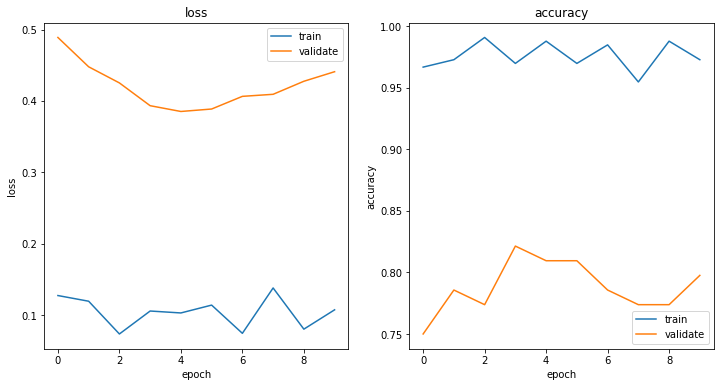

In [0]:
plot_history(history)

In [0]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 81.73% 
Test loss     = 0.435580


# Unseen data

In [0]:
def classify(img_url, class_type):
  response = requests.get(img_url)
  if response.status_code == 200:
    if(class_type == '6'):
      os.chdir('car-dataset/train/6')
      filename = str(max(sorted([int(prefix.split('.')[0]) for prefix in os.listdir()])) + 1)
    else:
      os.chdir('car-dataset/train/7')
      filename = str(max(sorted([int(prefix.split('.')[0]) for prefix in os.listdir()])) + 1)
    with open('{}.jpg'.format(filename), 'wb') as f:
        f.write(response.content)
        
  img = image.load_img('{}.jpg'.format(filename), target_size=(224, 224))
  os.chdir('../../..')
  plt.imshow(np.squeeze(img).astype('uint8'))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  print(model.predict_classes(img),  model.predict_proba(img))

## Golf 6

## Golf 7
